# Q Transform with Amplitude Modulation - Example Usage

We download a series of packages needed to download a gravitational wave and process it.

In [1]:
from gwosc.datasets import event_gps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import sys
import importlib

import matplotlib.pyplot as plt
import torch

from gwpy.timeseries import TimeSeries

from torchaudio import *
import pandas as pd

Here we download the QTAM package.

In [2]:
#sys.path.insert(1, '../')
from qtransform_gpu_2_5_0 import *
importlib.reload(sys.modules['qtransform_gpu_2_5_0'])
from qtransform_gpu_2_5_0 import *

Work with GPU if possible

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

We download two ten-seconds time series containing the GW events GW150914 and GW250114_082203.

In [4]:
events=['GW150914-v3','GW250114_082203-v1']
event_labels=['GW150914','GW250114_082203']
gps_list=[event_gps(event) for event in events]
dets=['L1','H1']
dets_label=['LIGO Livingston (L1)','LIGO Hanford (H1)']
ncols=len(dets)
nrows=3

denoising_threshold=7.
energy_density_threshold=7.

In [5]:
f_s=4096
f_range=[20., 2048.]
filmethod='highpass_threshold_filtering' 

In [6]:
detector=dets[1] # select the Hanford observatory

segment_list=[(gps-5, gps+5) for gps in gps_list] #choose 10 seconds intervals centred at the detection times
#data_init = TimeSeries.fetch_open_data(detector, *segment, verbose=True) # download data
#tensor_data=torch.tensor(data_init) #convert data to PyTorch tensor

In [7]:
data_init=[TimeSeries.fetch_open_data(detector, *segment, verbose=True) for segment in segment_list]
times_list=[np.arange(segment[0], segment[-1], 1./f_s) for segment in segment_list]

Fetched 1 URLs from gwosc.org for [1126259457 .. 1126259468))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1420878136 .. 1420878147))
Reading data... [Done]


In [8]:
data=[TimeSeries(data_init[i], x0=times_list[i][0], dx=times_list[i][1]-times_list[i][0], copy=False).whiten() for i in range(len(data_init))]
trange_list=[[gps-.15, gps+.05] for gps in gps_list]
data=[data[i].crop(trange_list[i][0], trange_list[i][-1]) for i in range(len(data))]
times_list=[data[i].times.value for i in range(len(data))]
data=[torch.tensor(data[i]) for i in range(len(data))]
data=torch.stack(data, dim=0)

We plot the two waves side by side.

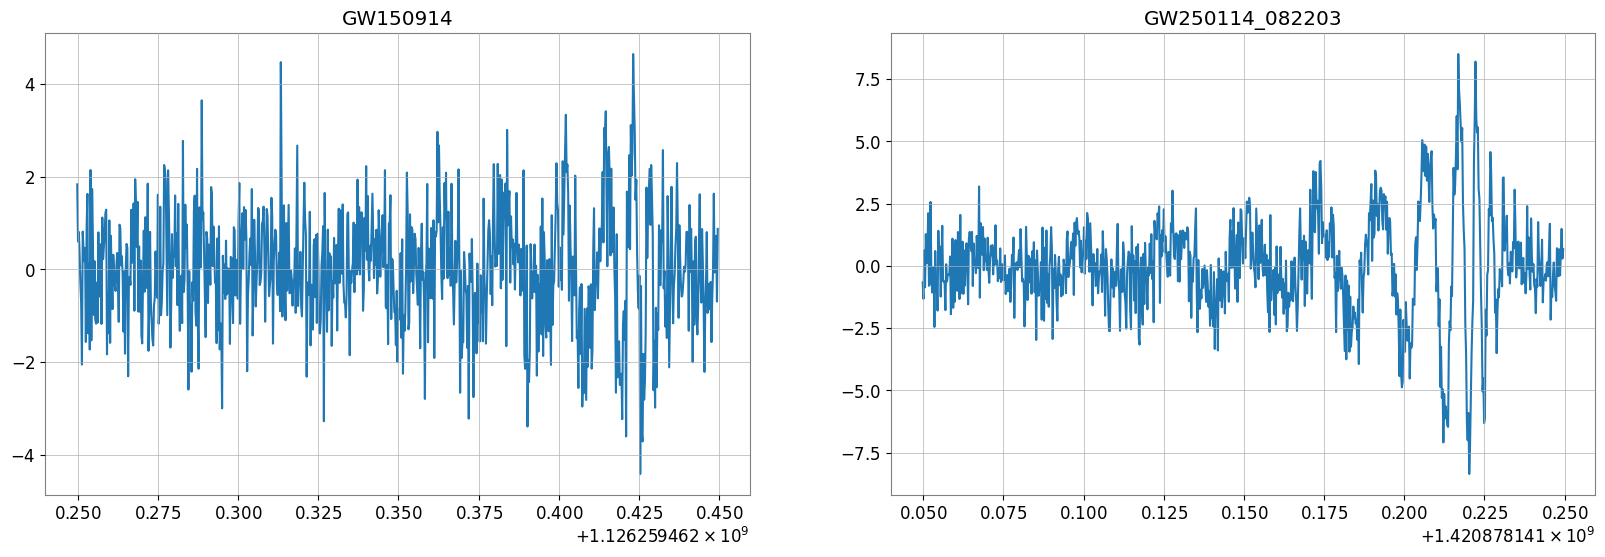

In [9]:
fig, axes= plt.subplots(1,2,figsize=(20,6))
for i in range(2):
    axes[i].plot(times_list[i],data[i].detach().cpu())
    axes[i].set_title(event_labels[i])

In [10]:
normalize=False #can be set True to help with visualisation, but needs to be false to ensure invertibility
energy_mode=True #if True, computes the energy in the time-frequency plane
phase_mode=True # if True, computes the phase in the time-frequency plane
interp_mode=None #'fourier' 
polar_mode=True # if True, represents complex values as Real *exp(i2Pi*Phase)
complex_mode=False # choose to output a single complex matrix or split it into two real ones

When inisialising the QTAM, we are free to set the maximum window. This parameter controls the **minimum number of time bins which we need to avoid information loss**.
There is a **theoretical minimum** below which it is not possible to decrease the number of time bins without loss of information. The code automatically detects this threshold and gives a warning if it is reached. Both the waves are processed together in batch.

We show the example of the warning if we choose a **max_window_size which is too small.**

In [11]:
duration=data.shape[-1]/f_s
Q=12. # we choose a fixed value of Q

In [12]:
size_too_small=13

qtransform = SingleQTransform(
     duration=duration,
     sample_rate=f_s,     
     q=Q,
     frange=f_range,
     logf=True,
     num_freq=64, 
     max_window_size=size_too_small
 )


start=time.time()
energy_too_small=qtransform(data, 
                        normalize=normalize,
                        energy_mode=energy_mode,
                        phase_mode=phase_mode,
                        interp_mode=interp_mode,
                        polar_mode=polar_mode,
                        complex_mode=complex_mode,
                        spectrogram_shape=None,
                        num_time=size_too_small).to('cpu')
print(time.time()-start)

[Info] Using user-defined max_window_size cap: 13
[Warning] User-defined cap (13) is smaller than the principled minimum (31) required to guarantee no frequency gaps. This may affect invertibility.

--- Downsampling Analysis ---
[Info] VQT mode detected with max_window_size = 13
[Info] No information loss detected.
       Your chosen T_out = 13 is sufficient for lossless resampling.
       (Minimum required T_out for this spectrogram is 13).
---------------------------

0.006776094436645508


We see that the code automatically gives the minimum number of frequency bins T_out=29 to avoid information loss. The QTAMs are still computed even if we choose a lower number, but the **information will be lost in some frequency range**. We can see this when we try to **invert the two QTAMs.**

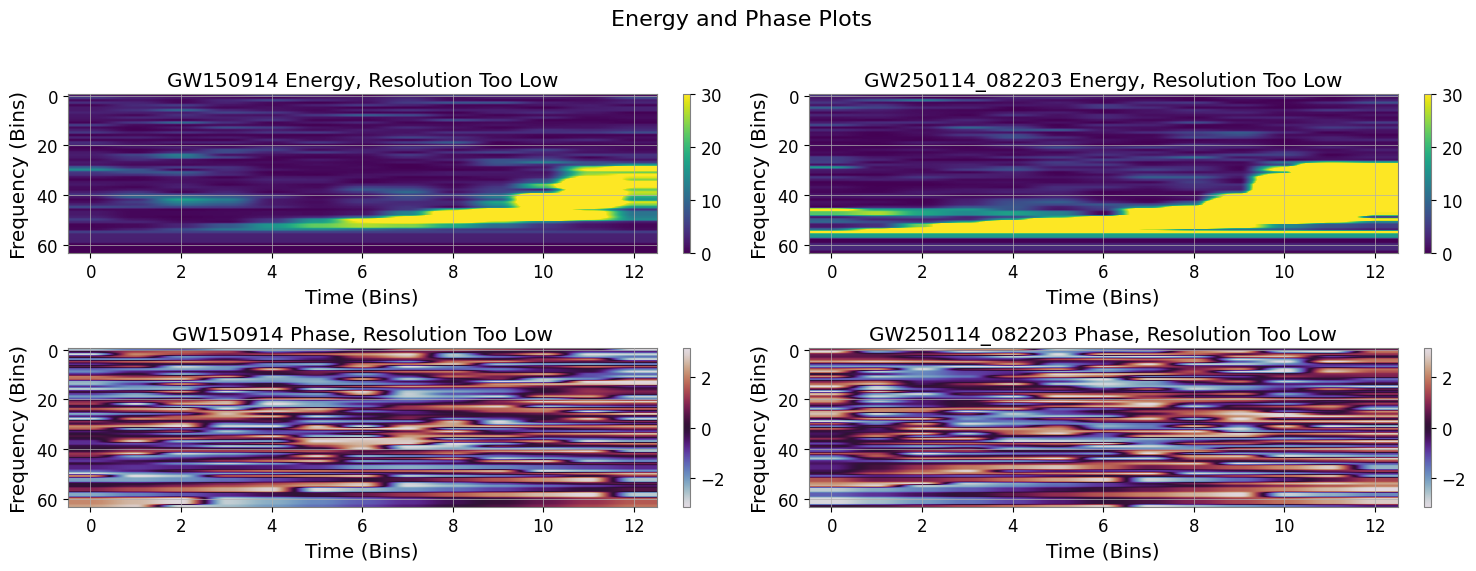

In [13]:
num_plots = energy_too_small.shape[1] 
# Create figure with num_plots rows and 2 columns. Increased figsize width for two plots side-by-side.
fig, axes = plt.subplots(num_plots, 2, figsize=(15, 3 * num_plots)) 

# Set common visualization limits
vmax_energy=30
vmin_energy = 0
vmax_phase = np.pi
vmin_phase = -np.pi

# Handle the case where there is only 1 row (axes might be 1D, so reshape to [1, 2])
if num_plots == 1:
    axes = np.array([axes])
# axes now has shape [num_plots, 2]
title_energy = [str(event_labels[i])+' Energy, Resolution Too Low' for i in range(num_plots)]
title_phase = [str(event_labels[i])+' Phase, Resolution Too Low' for i in range(num_plots)]

for i in range(num_plots):
    
    # --- 1. Energy Plot (Column 0) ---
    ax_energy = axes[0,i]
    # Slicing for Energy/Magnitude: [i, 0, 0]
    data_energy = energy_too_small[0, i, 0] 
    

    im_energy = ax_energy.imshow(
        np.flipud(data_energy.cpu().numpy()), 
        aspect='auto', 
        vmin=vmin_energy, 
        vmax=vmax_energy, 
        cmap='viridis'
    )
    ax_energy.set_title(title_energy[i])
    ax_energy.set_xlabel('Time (Bins)')
    ax_energy.set_ylabel('Frequency (Bins)')
    # Add colorbar for energy plot
    fig.colorbar(im_energy, ax=ax_energy, fraction=0.046, pad=0.04) 

    # --- 2. Phase Plot (Column 1) ---
    ax_phase = axes[1,i]
    # Slicing for Phase: [i, 0, 1]
    data_phase = energy_too_small[0, i, 1] 

    im_phase = ax_phase.imshow(
        np.flipud(data_phase.cpu().numpy()), 
        aspect='auto', 
        vmin=vmin_phase, 
        vmax=vmax_phase, 
        cmap='twilight' # 'twilight' is excellent for circular data like phase
    )
    ax_phase.set_title(title_phase[i])
    ax_phase.set_xlabel('Time (Bins)')
    ax_phase.set_ylabel('Frequency (Bins)')
    # Add colorbar for phase plot
    fig.colorbar(im_phase, ax=ax_phase, fraction=0.046, pad=0.04) 

fig.suptitle('Energy and Phase Plots', fontsize=16)
# Use plt.tight_layout for proper spacing, especially with colorbars
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 
plt.show()

Input spectrogram is downsampled (T=13). Upsampling to original T=410 before inversion...


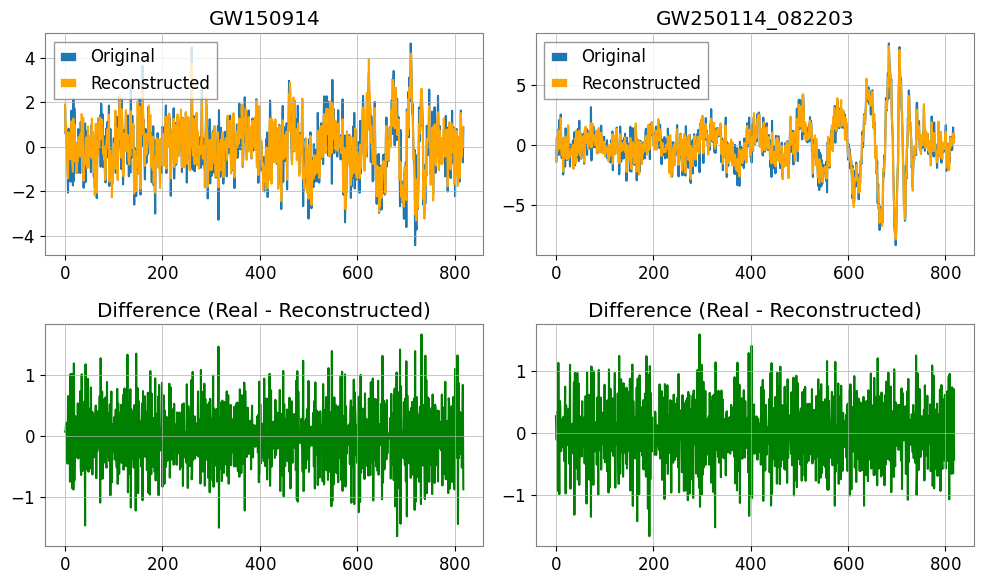

In [14]:
inverted_timeseries_too_small=qtransform.invert_qtransform(energy_too_small,idx=None, 
                        energy_mode=energy_mode,
                        phase_mode=phase_mode,
                        polar_mode=polar_mode,
                        complex_mode=complex_mode)

fig, axes=plt.subplots(2,2,figsize=(10,6))
diff=[]
for i in range(2):

    diff=inverted_timeseries_too_small[0][i]-data[i].detach().cpu()

    
    axes[0,i].plot(data[i].detach().cpu(), label='Original')
    axes[0,i].plot(inverted_timeseries_too_small[0][i], color='orange', label= 'Reconstructed')
    axes[1,i].plot(diff, color='green')

    axes[0,i].set_title(event_labels[i])
    axes[1,i].set_title('Difference (Real - Reconstructed)')

    axes[0,i].legend()
plt.tight_layout()
plt.show()

We then repeat the computation of the transform setting max_window_size=None, which automatically sets the number of time bins to f_s/2*duration+1. We notice that no warning is given in this case.

In [15]:
qtransform = SingleQTransform(
     duration=duration,
     sample_rate=f_s,     
     q=Q,
     frange=f_range,
     logf=True,
     num_freq=64, 
     max_window_size=None
 )



start=time.time()
energy=qtransform(data, 
                         normalize=normalize,
                         energy_mode=energy_mode,
                         phase_mode=phase_mode,
                         interp_mode=interp_mode,
                         polar_mode=polar_mode,
                         complex_mode=complex_mode,
                         spectrogram_shape=None,
                         num_time=None).to('cpu')
print(time.time()-start)

print(f'{energy.shape=}')

0.005930185317993164
energy.shape=torch.Size([1, 2, 2, 64, 410])


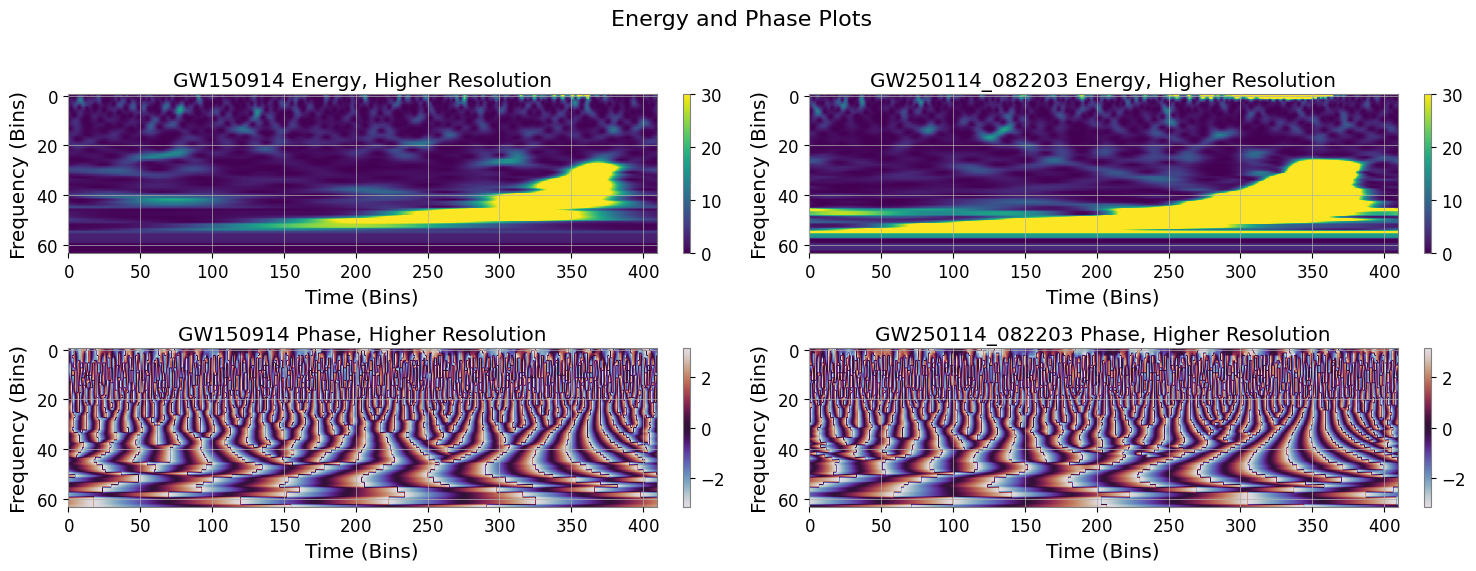

In [16]:
fig, axes = plt.subplots(num_plots, 2, figsize=(15, 3 * num_plots)) 

title_energy = [str(event_labels[i])+' Energy, Higher Resolution' for i in range(num_plots)]
title_phase = [str(event_labels[i])+' Phase, Higher Resolution' for i in range(num_plots)]

for i in range(num_plots):
    
    # --- 1. Energy Plot (Column 0) ---
    ax_energy = axes[0,i]
    # Slicing for Energy/Magnitude: [i, 0, 0]
    data_energy = energy[0, i, 0] 
    

    im_energy = ax_energy.imshow(
        np.flipud(data_energy.cpu().numpy()), 
        aspect='auto', 
        vmin=vmin_energy, 
        vmax=vmax_energy, 
        cmap='viridis'
    )
    ax_energy.set_title(title_energy[i])
    ax_energy.set_xlabel('Time (Bins)')
    ax_energy.set_ylabel('Frequency (Bins)')
    # Add colorbar for energy plot
    fig.colorbar(im_energy, ax=ax_energy, fraction=0.046, pad=0.04) 

    # --- 2. Phase Plot (Column 1) ---
    ax_phase = axes[1,i]
    # Slicing for Phase: [i, 0, 1]
    data_phase = energy[0, i, 1] 

    im_phase = ax_phase.imshow(
        np.flipud(data_phase.cpu().numpy()), 
        aspect='auto', 
        vmin=vmin_phase, 
        vmax=vmax_phase, 
        cmap='twilight' # 'twilight' is excellent for circular data like phase
    )
    ax_phase.set_title(title_phase[i])
    ax_phase.set_xlabel('Time (Bins)')
    ax_phase.set_ylabel('Frequency (Bins)')
    # Add colorbar for phase plot
    fig.colorbar(im_phase, ax=ax_phase, fraction=0.046, pad=0.04) 

fig.suptitle('Energy and Phase Plots', fontsize=16)
# Use plt.tight_layout for proper spacing, especially with colorbars
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 
plt.show()

We can then perform an **exact analytical inversion**. The differences in the original and reconstructed in both cases are below machine-error size.

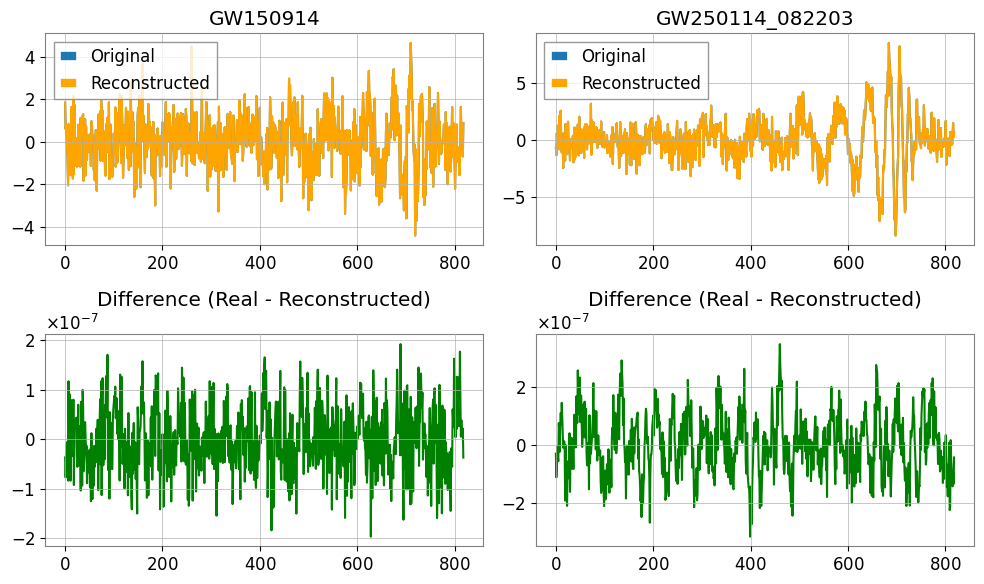

In [17]:
inverted_timeseries=qtransform.invert_qtransform(energy,idx=None, 
                        energy_mode=energy_mode,
                        phase_mode=phase_mode,
                        polar_mode=polar_mode,
                        complex_mode=complex_mode)


fig, axes=plt.subplots(2,2,figsize=(10,6))
diff=[]
for i in range(2):

    diff=inverted_timeseries[0][i]-data[i].detach().cpu()

    
    axes[0,i].plot(data[i].detach().cpu(), label='Original')
    axes[0,i].plot(inverted_timeseries[0][i], color='orange', label= 'Reconstructed')
    axes[1,i].plot(diff, color='green')

    axes[0,i].set_title(event_labels[i])
    axes[1,i].set_title('Difference (Real - Reconstructed)')

    axes[0,i].legend()
plt.tight_layout()
plt.show()

## Downsampling and Upsampling using Amplitude Modulation

In this section we show how the 2D QTAMs can be **down-sampled to smaller images**, which can be used in **ML and other applications** for which matrices of large sizes would be unfesable.
The function *downsample* applies **amplitude modulation (AM)** to downsize the input image by lowering its time resolution. 

In [18]:
lower_time_resolution = 227 #1659

energy_and_phase=energy.clone()
print(f'{energy_and_phase.shape=}')
original_time_resolution= energy_and_phase.shape[-1]

print("Running frequency-domain pipeline...")
#energy_and_phase_downsampled = qtransform.downsample(energy_and_phase, qtransform, lower_time_resolution, preserve_amplitude=True)

energy_and_phase_downsampled =qtransform.downsample(energy_and_phase, lower_time_resolution, polar_mode=True, 
                                                    energy_mode=True, phase_mode=True, complex_mode=False, 
                                                    preserve_amplitude=True)

print('Original size= '+str(energy_and_phase[0][0][0].shape))
print('Downsampled size= '+str(energy_and_phase_downsampled[0][0][0].shape))

energy_and_phase.shape=torch.Size([1, 2, 2, 64, 410])
Running frequency-domain pipeline...
frequency:20.0, idx:0, shift: 3
frequency:21.52481952447535, idx:1, shift: 4
frequency:23.165892778061746, idx:2, shift: 4
frequency:24.932083058556294, idx:3, shift: 4
frequency:26.83292941023268, idx:4, shift: 5
frequency:28.87869814341224, idx:5, shift: 5
frequency:31.08043828193749, idx:6, shift: 6
frequency:33.450041238014954, idx:7, shift: 6
frequency:36.000305036726466, idx:8, shift: 7
frequency:38.7450034370799, idx:9, shift: 7
frequency:41.69896032291608, idx:10, shift: 8
frequency:44.87812976545134, idx:11, shift: 8
frequency:48.29968218986626, idx:12, shift: 9
frequency:51.982097111319376, idx:13, shift: 10
frequency:55.94526294124501, idx:14, shift: 11
frequency:60.210584402980885, idx:15, shift: 12
frequency:64.80109813686765, idx:16, shift: 12
frequency:69.7415971191946, idx:17, shift: 13
frequency:75.05876456696667, idx:18, shift: 15
frequency:80.78131805170213, idx:19, shift: 16
f

Plot both the spectrogram both at the original and at the reduced resolution.

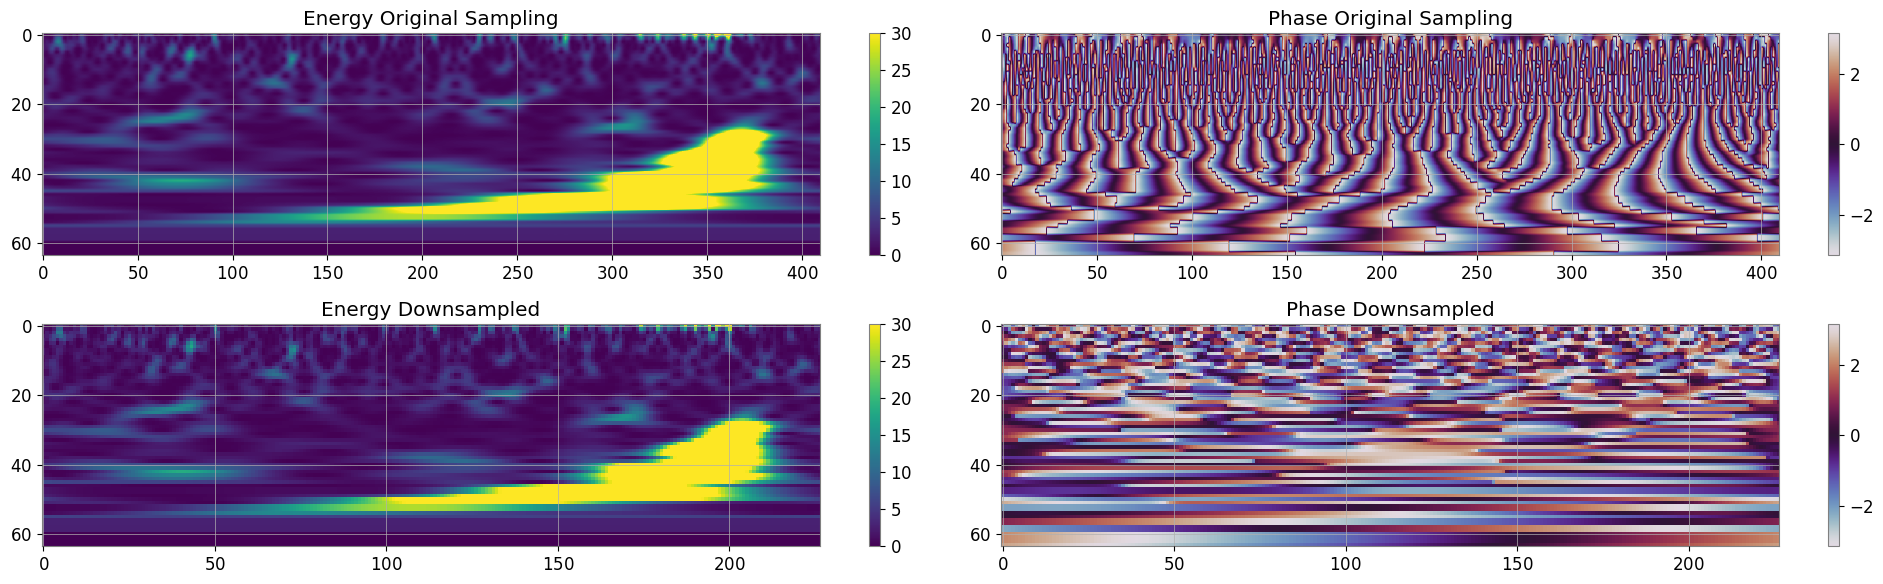

In [19]:
energy_original_sampling=energy_and_phase[0][0][0].detach().cpu()
phase_original_sampling=energy_and_phase[0][0][1].detach().cpu()

energy_downsampled=energy_and_phase_downsampled[0][0][0].detach().cpu()
phase_downsampled=energy_and_phase_downsampled[0][0][1].detach().cpu()


fig, axes= plt.subplots(2,2,figsize=(20,6))

im0=axes[0,0].imshow(np.flipud(energy_original_sampling), aspect='auto',vmin=vmin_energy, vmax=vmax_energy)
im1=axes[0,1].imshow(np.flipud(phase_original_sampling), aspect='auto', cmap='twilight')
im2=axes[1,0].imshow(np.flipud(energy_downsampled), aspect='auto', vmin=vmin_energy, vmax=vmax_energy)
im3=axes[1,1].imshow(np.flipud(phase_downsampled), aspect='auto', cmap='twilight')

axes[0,0].set_title('Energy Original Sampling')
axes[0,1].set_title('Phase Original Sampling')
axes[1,0].set_title('Energy Downsampled')
axes[1,1].set_title('Phase Downsampled')

fig.colorbar(im0, ax=axes[0,0])
fig.colorbar(im1, ax=axes[0,1])
fig.colorbar(im2, ax=axes[1,0])
fig.colorbar(im3, ax=axes[1,1])

plt.tight_layout()
plt.show()

The function *upsample_freq_domain* upsamples the downsampled image to bring it back to its original time-resolution.

In [20]:
#energy_and_phase_reupsampled= upsample_freq_domain(energy_and_phase_downsampled, qtransform, original_time_resolution, preserve_amplitude=True)

original_time_sampling=energy_and_phase.shape[-1]

energy_and_phase_reupsampled=qtransform.upsample(energy_and_phase_downsampled, T_in=original_time_sampling, polar_mode=True, energy_mode=True, 
        phase_mode=True, complex_mode=True, preserve_amplitude=True)




We plot the original images with the ones that have been re-upsampled and verify that no information was lost.

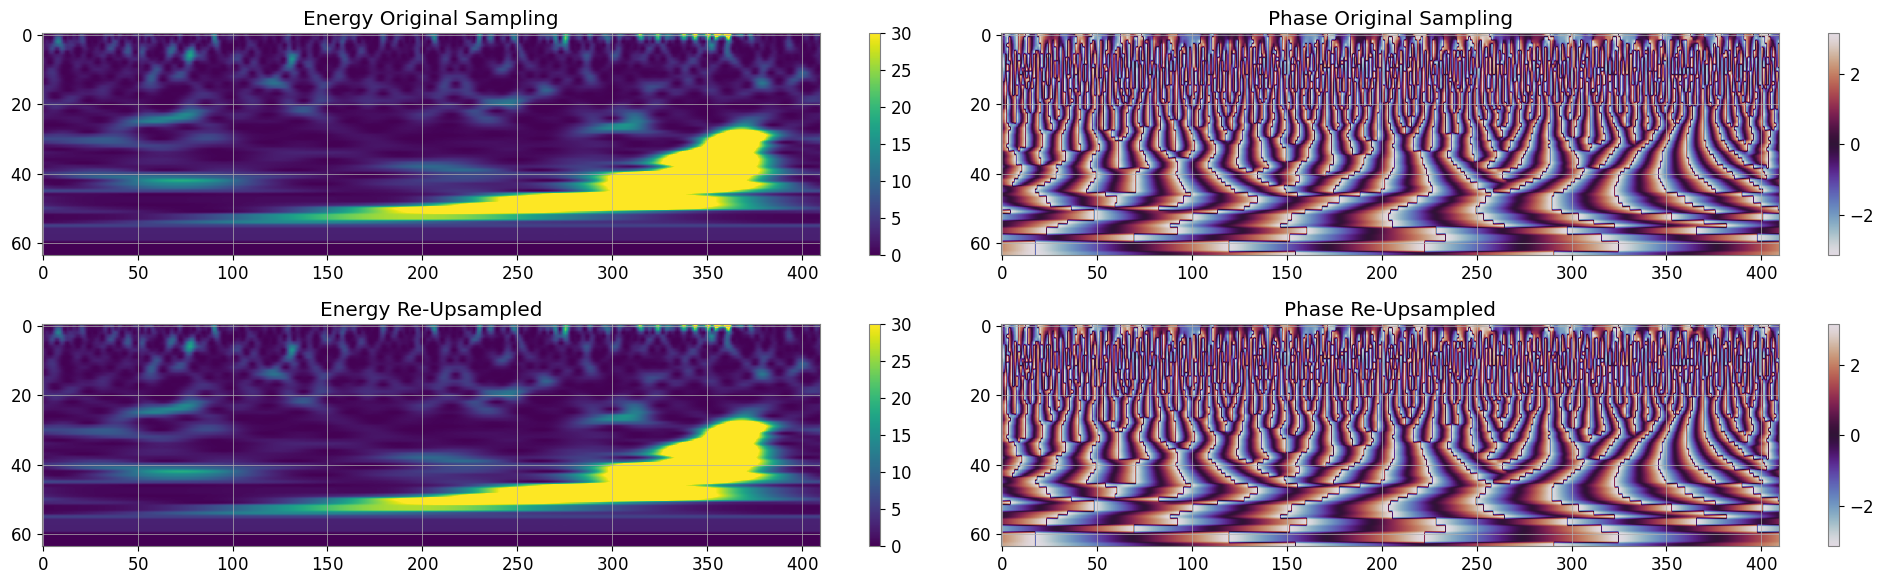

In [21]:
energy_reupsampled=energy_and_phase_reupsampled[0][0][0].detach().cpu()
phase_reupsampled=energy_and_phase_reupsampled[0][0][1].detach().cpu()

fig, axes= plt.subplots(2,2,figsize=(20,6))

im0=axes[0,0].imshow(np.flipud(energy_original_sampling), aspect='auto', vmin=vmin_energy, vmax=vmax_energy)
im1=axes[0,1].imshow(np.flipud(phase_original_sampling), aspect='auto', cmap='twilight')
im2=axes[1,0].imshow(np.flipud(energy_reupsampled), aspect='auto', vmin=vmin_energy, vmax=vmax_energy)
im3=axes[1,1].imshow(np.flipud(phase_reupsampled), aspect='auto', cmap='twilight')

axes[0,0].set_title('Energy Original Sampling')
axes[0,1].set_title('Phase Original Sampling')
axes[1,0].set_title('Energy Re-Upsampled')
axes[1,1].set_title('Phase Re-Upsampled')

fig.colorbar(im0, ax=axes[0,0])
fig.colorbar(im1, ax=axes[0,1])
fig.colorbar(im2, ax=axes[1,0])
fig.colorbar(im3, ax=axes[1,1])
plt.tight_layout()
plt.show()

We verify that the absolute difference between the original and re-upsampled spectrogram is of order 10^(-3). Since the spectrograms contain the **squared amplitude** of the signal, this indicates an **error between the amplitudes of 10^(-6).**

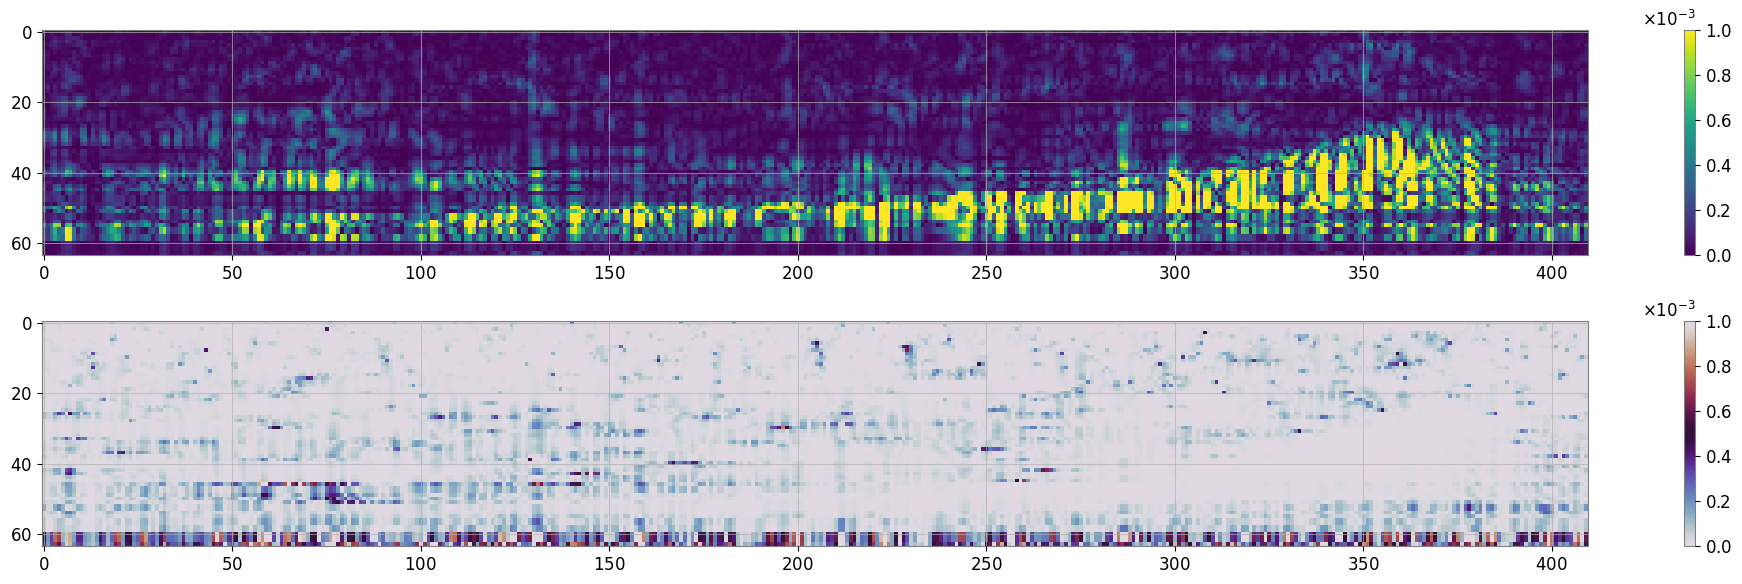

In [22]:
#relative_energy_error=torch.abs(energy_original_sampling-energy_reupsampled)/torch.abs(energy_original_sampling)
#relative_phase_error=torch.abs(phase_original_sampling-phase_reupsampled)/torch.abs(phase_original_sampling)
energy_diff=np.abs(energy_original_sampling-energy_reupsampled)
phase_diff=np.abs(phase_original_sampling-phase_reupsampled)

fig, axes= plt.subplots(2,1,figsize=(20,6))

im0=axes[0].imshow(np.flipud(energy_diff), aspect='auto', vmin=0, vmax=10**(-3))
im1=axes[1].imshow(np.flipud(phase_diff), aspect='auto', cmap='twilight', vmin=0, vmax=10**(-3))

fig.colorbar(im0, ax=axes[0])
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

In [23]:
inverted_timeseries_reupsampled=qtransform.invert_qtransform(energy_and_phase_reupsampled.detach().cpu(),idx=None, 
                        energy_mode=energy_mode,
                        phase_mode=phase_mode,
                        polar_mode=polar_mode,
                        complex_mode=complex_mode)

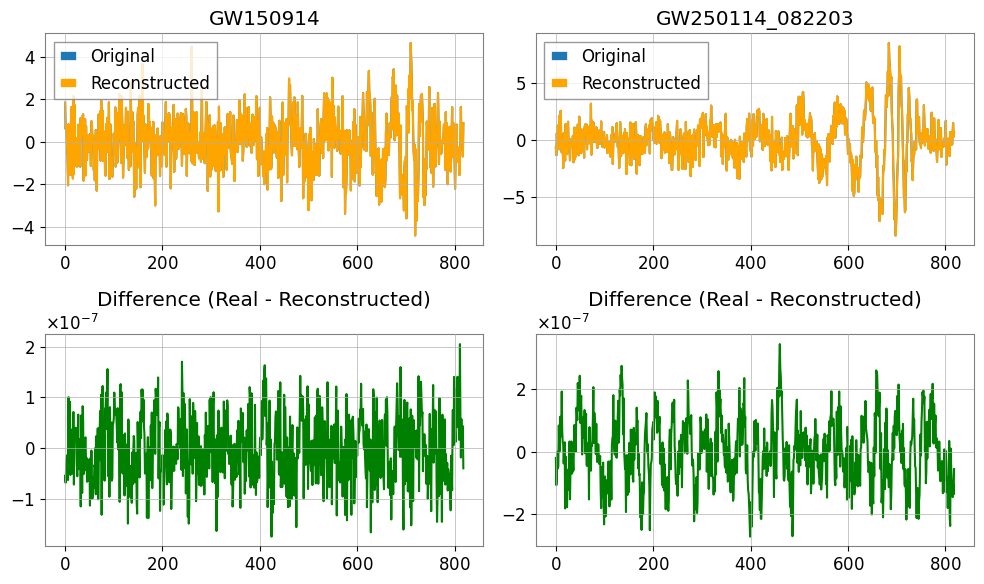

In [24]:
fig, axes=plt.subplots(2,2,figsize=(10,6))
diff=[]
for i in range(2):

    diff=inverted_timeseries_reupsampled[0][i]-data[i].detach().cpu()

    
    axes[0,i].plot(data[i].detach().cpu(), label='Original')
    axes[0,i].plot(inverted_timeseries_reupsampled[0][i], color='orange', label= 'Reconstructed')
    axes[1,i].plot(diff, color='green')

    axes[0,i].set_title(event_labels[i])
    axes[1,i].set_title('Difference (Real - Reconstructed)')

    axes[0,i].legend()
plt.tight_layout()
plt.show()